In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
train_set = pd.read_csv('data/trainingset.csv')

In [9]:
train_set.columns.tolist()

['id',
 'content',
 'location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience',
 'service_serving_speed',
 'price_level',
 'price_cost_effective',
 'price_discount',
 'environment_decoration',
 'environment_noise',
 'environment_space',
 'environment_cleaness',
 'dish_portion',
 'dish_taste',
 'dish_look',
 'dish_recommendation',
 'others_overall_experience',
 'others_willing_to_consume_again']

In [4]:
train_set.isnull().any()

id                                          False
content                                     False
location_traffic_convenience                False
location_distance_from_business_district    False
location_easy_to_find                       False
service_wait_time                           False
service_waiters_attitude                    False
service_parking_convenience                 False
service_serving_speed                       False
price_level                                 False
price_cost_effective                        False
price_discount                              False
environment_decoration                      False
environment_noise                           False
environment_space                           False
environment_cleaness                        False
dish_portion                                False
dish_taste                                  False
dish_look                                   False
dish_recommendation                         False


In [10]:
sentiments = train_set.columns.tolist()[2:]

In [11]:
sentiments

['location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience',
 'service_serving_speed',
 'price_level',
 'price_cost_effective',
 'price_discount',
 'environment_decoration',
 'environment_noise',
 'environment_space',
 'environment_cleaness',
 'dish_portion',
 'dish_taste',
 'dish_look',
 'dish_recommendation',
 'others_overall_experience',
 'others_willing_to_consume_again']

In [12]:
Y = train_set[sentiments].values

In [14]:
Y.shape

(105000, 20)

In [25]:
comments = train_set['content']

In [27]:
import jieba

def cut(content):
    return ' '.join(jieba.cut(content))

In [28]:
comments[:10]

0    "吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...
1    "第三次参加大众点评网霸王餐的活动。这家店给人整体感觉一般。首先环境只能算中等，其次霸王餐提...
2    "4人同行 点了10个小吃\n榴莲酥 榴莲味道不足 松软 奶味浓\n虾饺 好吃 两颗大虾仁\...
3    "之前评价了莫名其妙被删 果断继续差评！ 换了菜单 价格更低 开始砸牌子 但套餐还是有150...
4    "出乎意料地惊艳，椰子鸡清热降火，美容养颜，大大满足了爱吃火锅怕上火星人。椰子冻是帅帅的老板...
5    "烤鸭使用的蘸酱很地道，觉得烤鸭好不好吃在很大程度上都取决于这个酱料是否正宗。个人感觉他们家...
6    "在好友圈很红的原因很诡异.竟然基本都是我外地的朋友转发的.不远千里跑来厦门买回去吃.吃完各...
7    "中午饭点人比较多需要排队～2点左右去吃的刚好可以用团购～也不用排队～就是平安夜店员说的都不...
8    "跟朋友相约25号看港囧，首映当天排片率超高，为了提前订好票，选了文投国际影城，为了看电影我...
9    "首先感谢大众点评再次抽中我免费品尝火锅，同时也感谢古蜀雒味三星堆主题火锅商家提供这个平台，...
Name: content, dtype: object

In [32]:
X_w = list()
import tqdm

for c in tqdm.tqdm(comments):
    X_w.append(cut(c))

100%|█████████████████████████████████████████████████████████████████████████| 105000/105000 [03:35<00:00, 486.91it/s]


In [54]:
X_w[:3]

['" 吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了 。 一直 就 好奇 这个 棒棒糖 是 怎么 个 东西 ， 大众 点评 给 了 我 这个 土老冒 一个 见识 的 机会 。 看 介绍 棒棒糖 是 用 德国 糖 做 的 ， 不会 很甜 ， 中间 的 照片 是 糯米 的 ， 能 食用 ， 真是太 高端 大气 上档次 了 ， 还 可以 买 蝴蝶结 扎口 ， 送人 可以 买 礼盒 。 我 是 先 打 的 卖家 电话 ， 加 了 微信 ， 给 卖家 传 的 照片 。 等 了 几天 ， 卖家 就 告诉 我 可以 取货 了 ， 去 大官 屯 那取 的 。 虽然 连 卖家 的 面 都 没 见到 ， 但是 还是 谢谢 卖家 送 我 这么 可爱 的 东西 ， 太 喜欢 了 ， 这 哪 舍得吃 啊 。 "',
 '" 第三次 参加 大众 点评 网 霸王餐 的 活动 。 这家 店 给 人 整体 感觉 一般 。 首先 环境 只能 算 中等 ， 其次 霸王餐 提供 的 菜品 也 不是 很多 ， 当然 商家 为了 避免 参加 霸王餐 吃不饱 的 现象 ， 给 每桌 都 提供 了 至少 六份 主食 ， 我们 那桌 都 提供 了 两份 年糕 ， 第一次 吃火锅 会 在 桌上 有 这么 多 的 主食 了 。 整体 来说 这家 火锅店 没有 什么 特别 有 特色 的 ， 不过 每份 菜品 分量 还是 比较 足 的 ， 这点 要 肯定 ！ 至于 价格 ， 因为 没有 看 菜单 不 了解 ， 不过 我 看 大众 有 这家 店 的 团购 代金券 ， 相当于 7 折 ， 应该 价位 不会 很 高 的 ！ 最后 还是 要 感谢 商家 提供 霸王餐 ， 祝 生意兴隆 ， 财源 广进 "',
 '" 4 人 同行   点 了 10 个 小吃 \n 榴莲 酥   榴莲 味道 不足   松软   奶味 浓 \n 虾饺   好吃   两颗 大 虾仁 \n 皮蛋 粥   皮蛋 多   但是 一般   挺 稠 的 \n 奶黄包   很 好吃   真的 是 蛋黄 和 奶   而且 真的 是 流沙 \n 叉烧包   面香 \n 鲜虾 烧卖   好吃   外面 的 黄色 皮 看着 让 人 特别 有 食欲 \n 云吞面   云吞 分量 足   但是 汤头 不是 很 好喝   而且 云吞 的

In [35]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_w)
X_tokenized = tokenizer.texts_to_sequences(X_w)

In [39]:
tokenizer.word_counts.get('美味')

7355

In [40]:
comment_lens = [len(x) for x in tqdm.tqdm(X)]

100%|█████████████████████████████████████████████████████████████████████| 105000/105000 [00:00<00:00, 1783552.51it/s]


In [46]:
comment_lens[:20]

[367,
 379,
 504,
 387,
 404,
 503,
 1047,
 559,
 625,
 612,
 453,
 354,
 471,
 540,
 543,
 413,
 503,
 359,
 361,
 376]

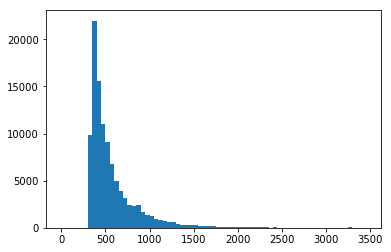

In [51]:
plt.hist(comment_lens, bins=np.arange(0,3500,50))
plt.show()

In [52]:
comment_max_len = 1000

In [55]:
X = pad_sequences(X_tokenized, maxlen=comment_max_len)

In [67]:
inp = Input(shape=(comment_max_len, ))

In [68]:
# can be opt
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [69]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [70]:
x = GlobalMaxPool1D()(x)

In [71]:
x = Dropout(0.1)(x)

In [72]:
x = Dense(50, activation="relu")(x)

In [73]:
x = Dropout(0.1)(x)

In [74]:
x = Dense(20, activation="sigmoid")(x)

In [75]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [76]:
batch_size = 32
epochs = 2
model.fit(X,Y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 94500 samples, validate on 10500 samples
Epoch 1/2


 6208/94500 [>.............................] - ETA: 1:54:03 - loss: 0.6923 - acc: 0.16 - ETA: 1:10:33 - loss: 0.6868 - acc: 0.15 - ETA: 55:58 - loss: 0.6815 - acc: 0.1458 - ETA: 48:50 - loss: 0.6778 - acc: 0.13 - ETA: 44:29 - loss: 0.6723 - acc: 0.13 - ETA: 41:34 - loss: 0.6671 - acc: 0.12 - ETA: 39:36 - loss: 0.6614 - acc: 0.12 - ETA: 38:02 - loss: 0.6548 - acc: 0.12 - ETA: 36:50 - loss: 0.6489 - acc: 0.13 - ETA: 35:53 - loss: 0.6407 - acc: 0.12 - ETA: 35:02 - loss: 0.6322 - acc: 0.12 - ETA: 34:16 - loss: 0.6236 - acc: 0.12 - ETA: 33:41 - loss: 0.6150 - acc: 0.12 - ETA: 33:10 - loss: 0.6022 - acc: 0.12 - ETA: 32:40 - loss: 0.5884 - acc: 0.12 - ETA: 32:13 - loss: 0.5710 - acc: 0.12 - ETA: 31:48 - loss: 0.5507 - acc: 0.12 - ETA: 31:34 - loss: 0.5271 - acc: 0.12 - ETA: 31:16 - loss: 0.5009 - acc: 0.12 - ETA: 30:58 - loss: 0.4681 - acc: 0.12 - ETA: 30:42 - loss: 0.4411 - acc: 0.12 - ETA: 30:27 - loss: 0.3998 - acc: 0.11 - ETA: 30:15 - loss: 0.3560 - acc: 0.11 - ETA: 30:04 - loss: 0.3170 -

12416/94500 [==>...........................] - ETA: 26:30 - loss: -12.4429 - acc: 0.10 - ETA: 26:30 - loss: -12.4709 - acc: 0.10 - ETA: 26:29 - loss: -12.4962 - acc: 0.10 - ETA: 26:29 - loss: -12.5250 - acc: 0.10 - ETA: 26:29 - loss: -12.5533 - acc: 0.10 - ETA: 26:28 - loss: -12.5716 - acc: 0.10 - ETA: 26:27 - loss: -12.6018 - acc: 0.10 - ETA: 26:26 - loss: -12.6272 - acc: 0.10 - ETA: 26:26 - loss: -12.6658 - acc: 0.10 - ETA: 26:25 - loss: -12.6834 - acc: 0.10 - ETA: 26:23 - loss: -12.7103 - acc: 0.10 - ETA: 26:22 - loss: -12.7290 - acc: 0.10 - ETA: 26:21 - loss: -12.7530 - acc: 0.10 - ETA: 26:20 - loss: -12.7715 - acc: 0.10 - ETA: 26:19 - loss: -12.7938 - acc: 0.10 - ETA: 26:18 - loss: -12.8226 - acc: 0.10 - ETA: 26:17 - loss: -12.8403 - acc: 0.10 - ETA: 26:16 - loss: -12.8671 - acc: 0.10 - ETA: 26:15 - loss: -12.8966 - acc: 0.10 - ETA: 26:14 - loss: -12.9206 - acc: 0.10 - ETA: 26:13 - loss: -12.9519 - acc: 0.10 - ETA: 26:12 - loss: -12.9811 - acc: 0.10 - ETA: 26:11 - loss: -13.0025 -

18624/94500 [====>.........................] - ETA: 23:55 - loss: -15.0642 - acc: 0.10 - ETA: 23:54 - loss: -15.0709 - acc: 0.10 - ETA: 23:54 - loss: -15.0798 - acc: 0.10 - ETA: 23:53 - loss: -15.0856 - acc: 0.10 - ETA: 23:52 - loss: -15.0924 - acc: 0.10 - ETA: 23:52 - loss: -15.0978 - acc: 0.10 - ETA: 23:51 - loss: -15.1025 - acc: 0.10 - ETA: 23:51 - loss: -15.1139 - acc: 0.10 - ETA: 23:50 - loss: -15.1223 - acc: 0.10 - ETA: 23:49 - loss: -15.1274 - acc: 0.10 - ETA: 23:49 - loss: -15.1351 - acc: 0.10 - ETA: 23:48 - loss: -15.1370 - acc: 0.10 - ETA: 23:47 - loss: -15.1441 - acc: 0.10 - ETA: 23:47 - loss: -15.1538 - acc: 0.10 - ETA: 23:46 - loss: -15.1608 - acc: 0.10 - ETA: 23:45 - loss: -15.1599 - acc: 0.10 - ETA: 23:45 - loss: -15.1697 - acc: 0.10 - ETA: 23:44 - loss: -15.1758 - acc: 0.10 - ETA: 23:43 - loss: -15.1811 - acc: 0.10 - ETA: 23:42 - loss: -15.1914 - acc: 0.10 - ETA: 23:42 - loss: -15.1993 - acc: 0.10 - ETA: 23:41 - loss: -15.2056 - acc: 0.10 - ETA: 23:40 - loss: -15.2095 -

24832/94500 [======>.......................] - ETA: 21:53 - loss: -15.9115 - acc: 0.10 - ETA: 21:52 - loss: -15.9156 - acc: 0.10 - ETA: 21:51 - loss: -15.9199 - acc: 0.10 - ETA: 21:50 - loss: -15.9210 - acc: 0.10 - ETA: 21:50 - loss: -15.9248 - acc: 0.10 - ETA: 21:49 - loss: -15.9294 - acc: 0.10 - ETA: 21:48 - loss: -15.9312 - acc: 0.10 - ETA: 21:48 - loss: -15.9332 - acc: 0.10 - ETA: 21:47 - loss: -15.9353 - acc: 0.10 - ETA: 21:47 - loss: -15.9358 - acc: 0.10 - ETA: 21:46 - loss: -15.9347 - acc: 0.10 - ETA: 21:45 - loss: -15.9384 - acc: 0.10 - ETA: 21:45 - loss: -15.9426 - acc: 0.10 - ETA: 21:44 - loss: -15.9445 - acc: 0.10 - ETA: 21:43 - loss: -15.9482 - acc: 0.10 - ETA: 21:43 - loss: -15.9512 - acc: 0.10 - ETA: 21:42 - loss: -15.9549 - acc: 0.10 - ETA: 21:41 - loss: -15.9578 - acc: 0.10 - ETA: 21:41 - loss: -15.9618 - acc: 0.10 - ETA: 21:40 - loss: -15.9659 - acc: 0.10 - ETA: 21:40 - loss: -15.9714 - acc: 0.10 - ETA: 21:39 - loss: -15.9711 - acc: 0.10 - ETA: 21:38 - loss: -15.9741 -

31040/94500 [========>.....................] - ETA: 20:03 - loss: -16.3405 - acc: 0.10 - ETA: 20:03 - loss: -16.3424 - acc: 0.10 - ETA: 20:02 - loss: -16.3461 - acc: 0.10 - ETA: 20:02 - loss: -16.3475 - acc: 0.10 - ETA: 20:01 - loss: -16.3501 - acc: 0.10 - ETA: 20:01 - loss: -16.3484 - acc: 0.10 - ETA: 20:00 - loss: -16.3504 - acc: 0.10 - ETA: 19:59 - loss: -16.3512 - acc: 0.10 - ETA: 19:59 - loss: -16.3538 - acc: 0.10 - ETA: 19:58 - loss: -16.3564 - acc: 0.10 - ETA: 19:58 - loss: -16.3583 - acc: 0.10 - ETA: 19:57 - loss: -16.3591 - acc: 0.10 - ETA: 19:57 - loss: -16.3596 - acc: 0.10 - ETA: 19:56 - loss: -16.3606 - acc: 0.10 - ETA: 19:55 - loss: -16.3614 - acc: 0.10 - ETA: 19:55 - loss: -16.3630 - acc: 0.10 - ETA: 19:55 - loss: -16.3646 - acc: 0.10 - ETA: 19:55 - loss: -16.3673 - acc: 0.10 - ETA: 19:54 - loss: -16.3677 - acc: 0.10 - ETA: 19:54 - loss: -16.3697 - acc: 0.10 - ETA: 19:54 - loss: -16.3705 - acc: 0.10 - ETA: 19:54 - loss: -16.3705 - acc: 0.10 - ETA: 19:54 - loss: -16.3709 -

37248/94500 [==========>...................] - ETA: 18:24 - loss: -16.5867 - acc: 0.10 - ETA: 18:23 - loss: -16.5880 - acc: 0.10 - ETA: 18:23 - loss: -16.5896 - acc: 0.10 - ETA: 18:23 - loss: -16.5916 - acc: 0.10 - ETA: 18:22 - loss: -16.5894 - acc: 0.10 - ETA: 18:22 - loss: -16.5914 - acc: 0.10 - ETA: 18:21 - loss: -16.5911 - acc: 0.10 - ETA: 18:21 - loss: -16.5929 - acc: 0.10 - ETA: 18:21 - loss: -16.5953 - acc: 0.10 - ETA: 18:20 - loss: -16.5971 - acc: 0.10 - ETA: 18:20 - loss: -16.5986 - acc: 0.10 - ETA: 18:20 - loss: -16.6005 - acc: 0.10 - ETA: 18:19 - loss: -16.6024 - acc: 0.10 - ETA: 18:19 - loss: -16.6038 - acc: 0.10 - ETA: 18:19 - loss: -16.6055 - acc: 0.10 - ETA: 18:19 - loss: -16.6051 - acc: 0.10 - ETA: 18:18 - loss: -16.6065 - acc: 0.10 - ETA: 18:18 - loss: -16.6068 - acc: 0.10 - ETA: 18:17 - loss: -16.6080 - acc: 0.10 - ETA: 18:16 - loss: -16.6090 - acc: 0.10 - ETA: 18:16 - loss: -16.6118 - acc: 0.10 - ETA: 18:15 - loss: -16.6130 - acc: 0.10 - ETA: 18:14 - loss: -16.6131 -

43456/94500 [============>.................] - ETA: 16:37 - loss: -16.7660 - acc: 0.10 - ETA: 16:37 - loss: -16.7677 - acc: 0.10 - ETA: 16:36 - loss: -16.7684 - acc: 0.10 - ETA: 16:36 - loss: -16.7687 - acc: 0.10 - ETA: 16:36 - loss: -16.7696 - acc: 0.10 - ETA: 16:35 - loss: -16.7696 - acc: 0.10 - ETA: 16:35 - loss: -16.7703 - acc: 0.10 - ETA: 16:35 - loss: -16.7718 - acc: 0.10 - ETA: 16:34 - loss: -16.7725 - acc: 0.10 - ETA: 16:34 - loss: -16.7728 - acc: 0.10 - ETA: 16:34 - loss: -16.7726 - acc: 0.10 - ETA: 16:33 - loss: -16.7729 - acc: 0.10 - ETA: 16:33 - loss: -16.7739 - acc: 0.10 - ETA: 16:33 - loss: -16.7756 - acc: 0.10 - ETA: 16:32 - loss: -16.7768 - acc: 0.10 - ETA: 16:32 - loss: -16.7780 - acc: 0.10 - ETA: 16:31 - loss: -16.7787 - acc: 0.10 - ETA: 16:30 - loss: -16.7780 - acc: 0.10 - ETA: 16:30 - loss: -16.7779 - acc: 0.10 - ETA: 16:29 - loss: -16.7780 - acc: 0.10 - ETA: 16:29 - loss: -16.7782 - acc: 0.10 - ETA: 16:28 - loss: -16.7781 - acc: 0.10 - ETA: 16:28 - loss: -16.7794 -

45952/94500 [=============>................] - ETA: 14:58 - loss: -16.8793 - acc: 0.10 - ETA: 14:57 - loss: -16.8801 - acc: 0.10 - ETA: 14:57 - loss: -16.8818 - acc: 0.10 - ETA: 14:56 - loss: -16.8817 - acc: 0.10 - ETA: 14:56 - loss: -16.8832 - acc: 0.10 - ETA: 14:55 - loss: -16.8836 - acc: 0.10 - ETA: 14:54 - loss: -16.8843 - acc: 0.10 - ETA: 14:54 - loss: -16.8859 - acc: 0.10 - ETA: 14:53 - loss: -16.8865 - acc: 0.10 - ETA: 14:53 - loss: -16.8886 - acc: 0.10 - ETA: 14:52 - loss: -16.8889 - acc: 0.10 - ETA: 14:51 - loss: -16.8887 - acc: 0.10 - ETA: 14:51 - loss: -16.8902 - acc: 0.10 - ETA: 14:50 - loss: -16.8914 - acc: 0.10 - ETA: 14:50 - loss: -16.8927 - acc: 0.10 - ETA: 14:49 - loss: -16.8939 - acc: 0.10 - ETA: 14:48 - loss: -16.8930 - acc: 0.10 - ETA: 14:48 - loss: -16.8940 - acc: 0.10 - ETA: 14:47 - loss: -16.8950 - acc: 0.10 - ETA: 14:46 - loss: -16.8942 - acc: 0.10 - ETA: 14:46 - loss: -16.8941 - acc: 0.10 - ETA: 14:45 - loss: -16.8954 - acc: 0.10 - ETA: 14:45 - loss: -16.8959 -

KeyboardInterrupt: 